# Strore Revenue Prediction<br>

The objective is to maximize revenue to open a new store in a retail or QSR (quick service restaurants) businesses while not impacting the existing stores of the same retail chain.


In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

import util

In [2]:
# Load data
df_train = pd.read_csv('./data/train.csv')
df_valid = pd.read_csv('./data/validation.csv')


df_train.head()

,date,directionCode,r_11,r_12,r_13,r_14,r_1e,r_21,r_22,r_23,...,weekend,transactCount,totalRevenue,Seats,Parking_slots,type_dtsf,mtype,isholiday,region,deltaRevenue
0,3/10/2019,3.0,0.779487,0.152542,0.250000,0.152542,0.000000,0.135593,0.876056,0.204819,...,no,71,42600,162,0,SF,Urban,no,1,-15.879277
1,5/12/2019,1.0,0.830565,0.164751,0.181818,0.166667,0.038206,0.134100,0.871275,0.078652,...,no,60,38190,100,13,DT,Urban,no,1,25.210486
2,21/02/2020,1.0,0.829023,0.132353,0.166667,0.116883,0.037356,0.161765,0.873127,0.128631,...,no,87,68780,100,13,DT,Urban,no,1,24.112387
3,23/10/2019,3.0,0.923077,0.000000,0.000000,0.250000,0.000000,0.000000,0.803030,0.118644,...,no,29,20670,64,80,DT,Suburban,no,2,-10.098617
4,8/09/2019,2.0,0.882172,0.215517,0.104408,0.159574,0.002049,0.181034,0.611285,0.094017,...,yes,97,118690,106,15,DT,Urban,no,1,7.282946


## 1. Exploring the Dataset<br>

In [3]:
print(f"Data shape: {df_train.shape}")
print(f"Data Types\n {df_train.dtypes}")

Data shape: (5059, 35)
Data Types
 date                         object
directionCode               float64
r_11                        float64
r_12                        float64
r_13                        float64
r_14                        float64
r_1e                        float64
r_21                        float64
r_22                        float64
r_23                        float64
r_24                        float64
r_2e                        float64
r_31                        float64
r_32                        float64
r_33                        float64
r_34                        float64
r_3e                        float64
r_41                        float64
r_42                        float64
r_43                        float64
r_44                        float64
r_4e                        float64
totalActivitiesRefcircle      int64
totalCustomersRefcircle       int64
dayname                      object
weekend                      object
transactCount                

## 1. Missing data

This dataset is filled with many missing values, therefore, all NA’s should be filled in with appropriate values before building any predictive model. For each column, the missing values were replaced by using features that have a strong correlation, which helps to determine what values to fill in.

               Total   Percent
directionCode     58  0.011465


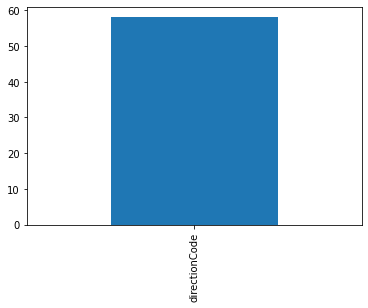

In [4]:
missing  = df_train.isnull().sum()
missing = missing[missing > 0]
total  = missing.sort_values(ascending=False)
percent = (missing/len(df_train)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print(missing_data)

#plot missing data
total.plot.bar()
plt.show()

We can see that directionCode feature has 58 missing values. Let's plot the histogram for this feature. 

/home/imagr/.virtualenvs/projects/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


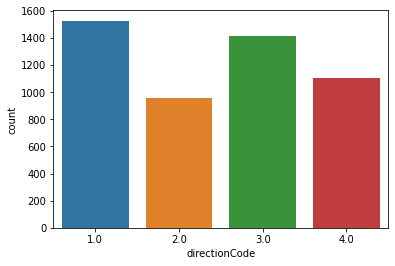

In [5]:
sns.countplot(df_train['directionCode'])
plt.show()

Since the histogram of store orientation almost uniform and 58 missing data is only a small percentage in the training dataset, we can simply remove rows with missing values.

In [6]:
# drop rows with missing values
df_train.dropna(inplace=True)
# summarize the shape of the data with missing rows removed
print(df_train.shape)

(5001, 35)


## 2. Feature construction

#### Step 1: extract features from date column

In [7]:
df_train = util.transform_datetime(df_train, 'date')
df_valid = util.transform_datetime(df_valid, 'date')

#### Step 2: data standardization
An important concern with this dataset is that the input attributes all vary in their scales because they measure different quantities. It is almost always good practice to scaled the data before buliding model.

In [8]:
columns = ['totalActivitiesRefcircle', 'totalCustomersRefcircle', 'transactCount', 'totalRevenue', 
               'Seats', 'Parking_slots']
df_train_sacled, df_valid_sacled = util.scale_features(df_train, df_valid, columns)

#### Step 3: encode categorical features

In [9]:
columns = ['dayname', 'weekend', 'type_dtsf', 'mtype', 'isholiday']
df_train_enc, df_valid_enc = util.encode_catogory_features(df_train, df_valid, columns)

## 3. Build model - XGBoost

In [10]:
y_train = df_train_enc['deltaRevenue']
x_train = df_train_enc.drop('deltaRevenue', axis=1)

df_valid_enc = df_valid_enc[df_train_enc.columns]
y_test = df_valid_enc['deltaRevenue']
x_test = df_valid_enc.drop('deltaRevenue', axis=1)

### Baseline model
Baseline model provides a point of comparison for the model that will be evaluated later. 

In [11]:
# Baseline model
model = xgb.XGBRegressor(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=2,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     n_jobs=2,
     scale_pos_weight=1,
     random_state=42)


#Fit the algorithm on the data
model.fit(x_train, y_train, eval_metric='rmse', verbose=False)

y_train_pred = model.predict(x_train)
y_train_pred = [value for value in y_train_pred]
# evaluate predictions
y_train_true = y_train.values
print("train RMSE: %f" % (np.sqrt(mean_squared_error(y_train_true, y_train_pred))))

train RMSE: 2.419822


### Parameter tuning
#### Step 1: tune max_depth and min_child_weight

In [12]:
# Tune max_depth and min_child_weight
model = xgb.XGBRegressor(
     learning_rate=0.1,
     n_estimators=150,
     max_depth=5,
     min_child_weight=2,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     n_jobs=2,
     scale_pos_weight=1,
     random_state=42)

# define the grid search parameters
param_test = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch = GridSearchCV(estimator=model, scoring="neg_mean_squared_error", n_jobs=-1,
                        param_grid=param_test, verbose=0)
gsearch.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (gsearch.best_score_, gsearch.best_params_))

Best: -31834.108979 using {'max_depth': 5, 'min_child_weight': 5}


#### Step 2: tune gamma

In [13]:
# Tune gamma
model = xgb.XGBRegressor(
     learning_rate=0.1,
     n_estimators=150,
     max_depth=5,
     min_child_weight=5,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     n_jobs=2,
     scale_pos_weight=1,
     random_state=42)

# define the grid search parameters
# best parameters {'gamma': 0.0}
param_test = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch = GridSearchCV(estimator=model, scoring="neg_mean_squared_error", n_jobs=-1,
                        param_grid=param_test, verbose=0)
gsearch.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (gsearch.best_score_, gsearch.best_params_))

Best: -31834.108979 using {'gamma': 0.0}


#### Step 3: tune subsample and colsample_bytree

In [ ]:
# Tune subsample and colsample_bytree
model = xgb.XGBRegressor(
     learning_rate=0.1,
     n_estimators=150,
     max_depth=5,
     min_child_weight=5,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     n_jobs=2,
     scale_pos_weight=1,
     random_state=42)

# define the grid search parameters
# best parameters {'colsample_bytree': 0.6, 'subsample': 0.8}
subsample = [i/100.0 for i in range(10,110,10)]
colsample_bytree = [i/100.0 for i in range(10,110,10)]

param_test = {
 'subsample': subsample,
 'colsample_bytree':colsample_bytree
}

gsearch = GridSearchCV(estimator=model, scoring="neg_mean_squared_error", n_jobs=-1,
                        param_grid=param_test, verbose=0)
gsearch.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (gsearch.best_score_, gsearch.best_params_))

#### Step 4: tuning Regularization Parameters

In [ ]:
# Tuning Regularization Parameters
model = xgb.XGBRegressor(
     learning_rate=0.1,
     n_estimators=150,
     max_depth=5,
     min_child_weight=5,
     gamma=0,
     subsample=0.2,
     colsample_bytree=1,
     n_jobs=2,
     scale_pos_weight=1,
     random_state=42)

# define the grid search parameters
# best parameters {'reg_alpha': 0.005}
param_test = {
  'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

gsearch = GridSearchCV(estimator=model, scoring="neg_mean_squared_error", n_jobs=-1,
                        param_grid=param_test, verbose=0)
gsearch.fit(x_train,y_train)

# summarize results
print("Best: %f using %s" % (gsearch.best_score_, gsearch.best_params_))

### Final model
Finalizing the model involves fitting the final model on on the entire train dataset and saving the model for later use.

In [ ]:
model = xgb.XGBRegressor(
     learning_rate=0.1,
     n_estimators=150,
     max_depth=5,
     min_child_weight=5,
     gamma=0,
     subsample=0.2,
     colsample_bytree=1,
     n_jobs=2,
     scale_pos_weight=1,
     random_state=42,
     reg_alpha=0.001)

# Save final model (combine train and validation)
model.fit(x_train, y_train, eval_metric='rmse')

# save model
print("Saving model")
pickle.dump(model, open('./outputs/finalized_model.sav', 'wb'))   

### Feature importance
Feature importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

In [ ]:
# load model
loaded_model = pickle.load(open('./outputs/finalized_model.sav', 'rb'))

#Plot important
xgb.plot_importance(loaded_model, max_num_features = 20)
plt.show()

### Model validation

In [ ]:
# make predictions for test data
y_test_pred = loaded_model.predict(x_test)
y_test_pred = [value for value in y_test_pred]
# evaluate predictions
y_test_real = y_test.values
print("test RMSE: %f" % (np.sqrt(mean_squared_error(y_test_real, y_test_pred))))